This file is used to train the Elastic Net model.

In [1]:
import pandas as pd
import numpy as np
import gc
import os
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt

First, based on the definition in the paper, we construct the ROS function to evaluate the model performance.

In [2]:
def r2_oos(y_true, y_pred):

    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    mask = (~np.isnan(y_true)) & (~np.isnan(y_pred))
    y, yp = y_true[mask], y_pred[mask]
    rss, tss = np.sum((y - yp) ** 2), np.sum(y ** 2)
    return 1 - rss / tss if tss > 0 else np.nan


`fast_impute_scale()` is a low-memory version of the missing value imputation and standardization function, used for fast preprocessing of feature matrices in machine learning rolling validation or large-scale financial panel data processing.

Compared to using `simpleImputer + StandardScaler` in `sklearn`, this function avoids object initialization and multiple data copying operations, saving more memory and running faster.

In [3]:
def fast_impute_scale(X, mean=None, std=None):

    X = np.nan_to_num(X, nan=0.0, copy=False)
    if mean is None or std is None:
        mean, std = X.mean(0), X.std(0)
    std[std == 0] = 1.0
    X = (X - mean) / std
    return X.astype(np.float32), mean, std

The `elasticnet_rolling_validation()` function implements annual rolling out-of-sample prediction validation based on ElasticNet regression, used to evaluate the robustness of financial asset pricing models across different time periods.

This function follows the rolling window setting of **Gu, Kelly & Xiu (2020)**, and in each validation year, it searches for the optimal combination of hyperparameters using a grid search (`α`, `L1_ratio`), and calculates the annual and overall out-of-sample R^2_{OOS}.

In [4]:
def elasticnet_rolling_validation(
    data_path="features.parquet",
    result_dir="../data/result",
    train_start=1957,
    test_start=1987,
    test_end=2016,
    target="ret_excess_t_plus_1",
    alphas=np.logspace(-4, -1, 6),
    l1_ratios=[0.1, 0.5, 0.9]
):


    os.makedirs(result_dir, exist_ok=True)
    param_path = os.path.join(result_dir, "elasticnet_best_params.parquet")

    print(f"Loading data from {data_path} ...")
    df = pd.read_parquet(data_path)
    df["month"] = pd.to_datetime(df["month"], errors="coerce")
    df["year"] = df["month"].dt.year

    feature_cols = [c for c in df.columns if c.startswith(("c_", "m_", "sic_"))]
    df[feature_cols] = df[feature_cols].astype("float32")
    df = df.dropna(subset=[target]).reset_index(drop=True)

    print(f"Total features used: {len(feature_cols)}")


    annual_r2, all_y_true, all_y_pred, param_records = [], [], [], []

    for Y in range(test_start, test_end + 1):

        tr_mask = (df["year"] >= train_start) & (df["year"] <= Y - 13)
        va_mask = (df["year"] >= Y - 12) & (df["year"] <= Y - 1)
        te_mask = (df["year"] == Y)

        df_tr, df_va, df_te = df.loc[tr_mask], df.loc[va_mask], df.loc[te_mask]
        if df_te.empty:
            continue

        X_tr = df_tr[feature_cols].to_numpy(copy=False)
        y_tr = df_tr[target].to_numpy(copy=False)
        X_va = df_va[feature_cols].to_numpy(copy=False)
        y_va = df_va[target].to_numpy(copy=False)
        X_te = df_te[feature_cols].to_numpy(copy=False)
        y_te = df_te[target].to_numpy(copy=False)

        X_tr_s, mean, std = fast_impute_scale(X_tr)
        X_va_s, _, _ = fast_impute_scale(X_va, mean, std)
        X_te_s, _, _ = fast_impute_scale(X_te, mean, std)

        best_r2, best_a, best_l1 = -np.inf, None, None
        for l1 in l1_ratios:
            for a in alphas:
                model = ElasticNet(alpha=a, l1_ratio=l1, max_iter=3000, random_state=42)
                model.fit(X_tr_s, y_tr)
                yhat_val = model.predict(X_va_s)
                r2_val = r2_oos(y_va, yhat_val)
                if not np.isnan(r2_val) and r2_val > best_r2:
                    best_r2, best_a, best_l1 = r2_val, a, l1

        X_trva = np.vstack([X_tr, X_va])
        y_trva = np.concatenate([y_tr, y_va])
        X_trva_s, mean_final, std_final = fast_impute_scale(X_trva)
        X_te_s_final, _, _ = fast_impute_scale(X_te, mean_final, std_final)

        final_model = ElasticNet(alpha=best_a, l1_ratio=best_l1, max_iter=5000, random_state=42)
        final_model.fit(X_trva_s, y_trva)

        yhat_te = final_model.predict(X_te_s_final)
        r2_test = r2_oos(y_te, yhat_te)

        annual_r2.append({"year": Y, "r2_oos": r2_test})
        all_y_true.append(pd.Series(y_te))
        all_y_pred.append(pd.Series(yhat_te))
        param_records.append({"year": Y, "alpha": best_a, "l1_ratio": best_l1})

        print(f"[ElasticNet] {Y}: R²={r2_test:.6f}, α={best_a:.5f}, L1={best_l1}")

        del X_tr, X_va, X_te, X_tr_s, X_va_s, X_te_s, X_trva, X_trva_s, X_te_s_final
        gc.collect()

    df_r2 = pd.DataFrame(annual_r2)
    df_params = pd.DataFrame(param_records)
    y_true_all = pd.concat(all_y_true, ignore_index=True)
    y_pred_all = pd.concat(all_y_pred, ignore_index=True)

    overall_r2 = r2_oos(y_true_all, y_pred_all)
    mean_annual_r2 = df_r2["r2_oos"].mean()
    median_annual_r2 = df_r2["r2_oos"].median()

    print("\n================= R² Summary =================")
    print(f"Overall R² (Eq.19)   = {overall_r2:.6f}")
    print(f"Mean Annual R²        = {mean_annual_r2:.6f}")
    print(f"Median Annual R²      = {median_annual_r2:.6f}")
    print("================================================")


    df_params.to_parquet(param_path, index=False)
    print(f" Saved best yearly parameters to {param_path}")

    plt.figure(figsize=(10, 5))
    plt.plot(df_r2["year"], df_r2["r2_oos"], marker="o", label="ElasticNet Annual R²")
    plt.axhline(0, color="gray", ls="--")
    plt.axhline(overall_r2, color="red", ls="--", alpha=0.7, label=f"Overall R²={overall_r2:.4f}")
    plt.title("ElasticNet — Annual Out-of-Sample R² (Low-Memory)")
    plt.xlabel("Year")
    plt.ylabel("R²_oos")
    plt.legend()
    plt.grid(ls="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    return df_r2, df_params, overall_r2

building main function and run it.

Loading data from features.parquet ...
Total features used: 176
[ElasticNet] 1987: R²=0.028952, α=0.00158, L1=0.9
[ElasticNet] 1988: R²=0.001928, α=0.00158, L1=0.9
[ElasticNet] 1989: R²=0.002376, α=0.00158, L1=0.9
[ElasticNet] 1990: R²=0.000500, α=0.00631, L1=0.9
[ElasticNet] 1991: R²=0.007637, α=0.00631, L1=0.9
[ElasticNet] 1992: R²=0.000231, α=0.00158, L1=0.9
[ElasticNet] 1993: R²=0.006689, α=0.00631, L1=0.9
[ElasticNet] 1994: R²=0.007782, α=0.00158, L1=0.5
[ElasticNet] 1995: R²=-0.005273, α=0.00631, L1=0.1
[ElasticNet] 1996: R²=-0.025036, α=0.00040, L1=0.9
[ElasticNet] 1997: R²=0.002031, α=0.00631, L1=0.9
[ElasticNet] 1998: R²=-0.000533, α=0.00631, L1=0.9
[ElasticNet] 1999: R²=0.003692, α=0.00631, L1=0.9
[ElasticNet] 2000: R²=-0.000307, α=0.10000, L1=0.1
[ElasticNet] 2001: R²=-0.000970, α=0.10000, L1=0.1
[ElasticNet] 2002: R²=-0.004344, α=0.10000, L1=0.1
[ElasticNet] 2003: R²=0.016944, α=0.10000, L1=0.1
[ElasticNet] 2004: R²=0.003446, α=0.10000, L1=0.1
[ElasticNet] 2005: R²=0.006601

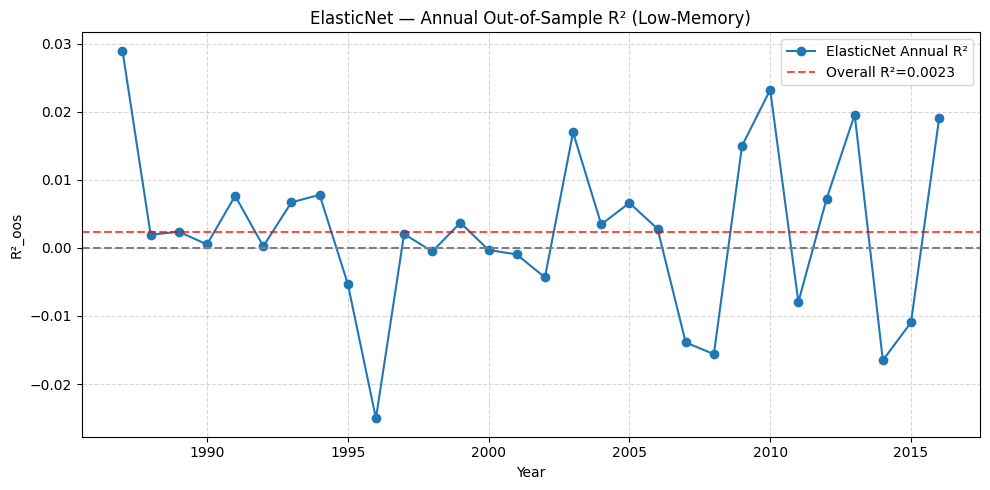

 ElasticNet rolling validation complete.
 Final Overall R² = 0.002292


In [5]:
def main():
    df_r2, df_params, overall_r2 = elasticnet_rolling_validation()
    print(" ElasticNet rolling validation complete.")
    print(f" Final Overall R² = {overall_r2:.6f}")


if __name__ == "__main__":
    main()